# Main of the paper - LSR - $\sigma \neq 0.4$

In this notebook are gathered all experiments generated for the main of the paper using a least-squares regression which require presence of noise.

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, DianaDescent, FL_VanillaSGD
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataPreparation import build_data_linear, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "with_noise"

nb_devices_for_the_run = 20
dim_notebook = 20

In [2]:
# Building data
w_true = generate_param(dim_notebook)
X, Y = build_data_linear(w_true, n_dimensions = dim_notebook, 
                         n_devices=nb_devices_for_the_run, with_seed=False, without_noise=False)
X = add_bias_term(X)
print(X[0].shape)
pickle_saver((X, Y), filename + "-data")

torch.Size([200, 21])


Text(0.5, 1.0, 'Model weights')

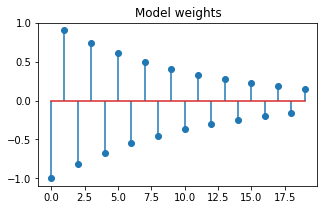

In [3]:
plt.figure(figsize=(5, 3))
plt.stem(w_true, use_line_collection=True)
plt.title("Model weights")

In [4]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X, Y, nb_devices_for_the_run)

In [5]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                     nb_devices=nb_devices_for_the_run,
                                                     nb_epoch=20000, 
                                                     momentum=0., 
                                                     quantization_param=0,
                                                     verbose=True, 
                                                     cost_models=cost_models,
                                                     stochastic=False,
                                                     bidirectional=False,
                                                    ))
obj_min_by_N_descent.run(cost_models)
obj_min_by_N = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")

   it    |   obj   
    4000 | 1.8496e-01
    8000 | 1.8496e-01
   12000 | 1.8496e-01
   16000 | 1.8496e-01
Gradient Descent: execution time=160.663 seconds
Final loss : 0.18496

CPU times: user 2min 41s, sys: 205 ms, total: 2min 41s
Wall time: 2min 40s


In [6]:
obj_min_by_N_descent.model_params[-1]

tensor([ 1.9102, -0.9973,  0.8910, -0.8140,  0.7308, -0.6597,  0.5960, -0.5468,
         0.4922, -0.4295,  0.4052, -0.3665,  0.3319, -0.2984,  0.2833, -0.2544,
         0.2317, -0.2081,  0.1886, -0.1702,  0.1524], dtype=torch.float64)

In [7]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               step_formula=deacreasing_step_size)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

100%|██████████| 5/5 [1:32:33<00:00, 1110.80s/it]

CPU times: user 1h 16min 53s, sys: 2.87 s, total: 1h 16min 56s
Wall time: 1h 32min 34s


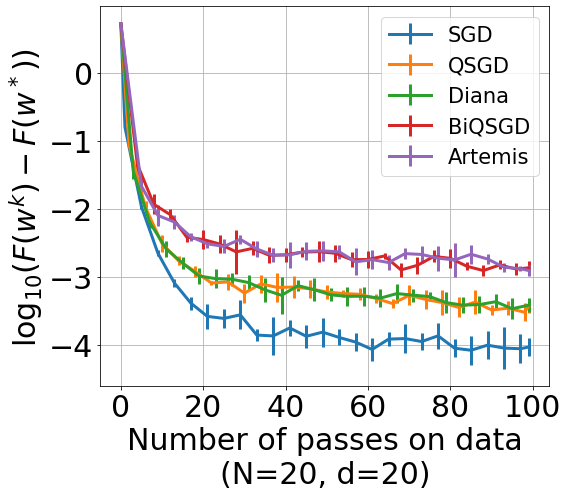

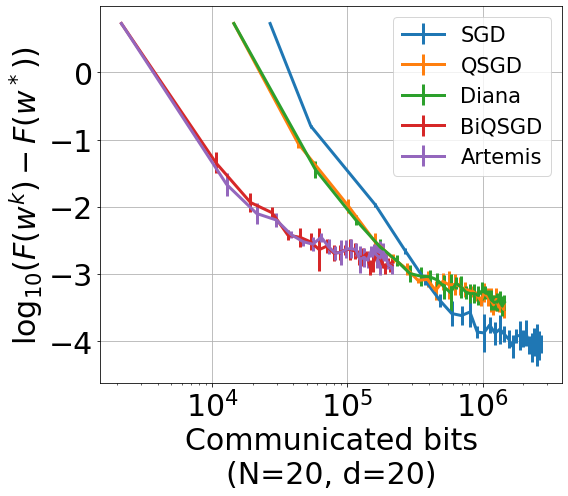

In [8]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj))  


## Devices sampling

In [9]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               step_formula=deacreasing_step_size, fraction_sampled_workers=0.5)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

100%|██████████| 5/5 [1:15:34<00:00, 906.97s/it]

CPU times: user 47min 28s, sys: 1.67 s, total: 47min 30s
Wall time: 1h 15min 34s


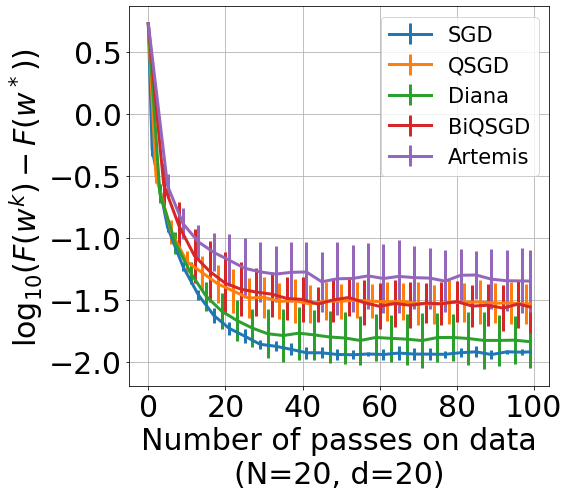

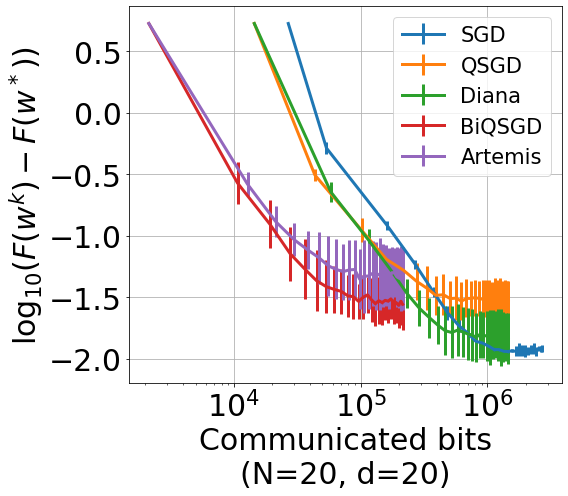

In [10]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj))  
